# Pareto-NBD Population Model



#### References:
----------
David C. Schmittlein, Donald G. Morrison and Richard Colombo
Management Science,Vol. 33, No. 1 (Jan., 1987), pp. 1-24
"Counting Your Customers: Who Are They and What Will They Do Next,"
    
Fader, Peter & G. S. Hardie, Bruce (2005).
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](http://brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import numpy as np
import warnings

from lifetimes import ParetoNBDFitter

from pymc_marketing.clv.models.pareto_nbd import ParetoNBDModel
from pymc_marketing.clv.distributions import ParetoNBD
from pymc_marketing.clv.utils import clv_summary

## Load Data

We will be working with the CDNOW Sample dataset, a common benchmark dataset in research for CLV and BTYD models

In [2]:
url_cdnow_rfm = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/datasets/clv_quickstart.csv"
url_cdnow_trans = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/tests/clv/datasets/cdnow_transactions.csv"
df = pd.read_csv(url_cdnow_rfm)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       2357 non-null   int64  
 1   recency         2357 non-null   float64
 2   T               2357 non-null   float64
 3   monetary_value  2357 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 73.8 KB


In [3]:
df.head(5)

,frequency,recency,T,monetary_value
0,2,30.43,38.86,22.35
1,1,1.71,38.86,11.77
2,0,0.00,38.86,0.00
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00


In [4]:
df.describe()

,frequency,recency,T,monetary_value
count,2357.000000,2357.000000,2357.000000,2357.000000
mean,1.042427,6.845787,32.715829,14.079045
std,2.190014,10.731400,3.326906,25.760960
min,0.000000,0.000000,27.000000,0.000000
25%,0.000000,0.000000,29.860000,0.000000
50%,0.000000,0.000000,32.710000,0.000000
75%,1.000000,12.000000,35.430000,21.360000
max,29.000000,38.430000,38.860000,299.630000


In [5]:
x = df["frequency"].values
t_x = df["recency"].values
T = df["T"].values

## Lifetimes Comparison

In [6]:
lft = ParetoNBDFitter()
lft.fit(x, t_x, T)

<lifetimes.ParetoNBDFitter: fitted with 2357 subjects, alpha: 10.58, beta: 11.67, r: 0.55, s: 0.61>

In [7]:
lt_fit = dict(lft.params_)
ParetoNBDFitter._conditional_log_likelihood(list(lt_fit.values()), x, t_x, T).sum()

-9594.97392991274

## PyMC Comparison

Construct an equivalent model with PyMC to illustrate the inner workings of the pymc-marketing model for comparison. 

This model uses Weibull default priors. For an interactive PDF go here:
https://homepage.divms.uiowa.edu/~mbognar/applets/weibull.html

The Weibull distribution is an intuitive prior distribution choice for the Pareto/NBD model because the `beta` parameter loosely corresponds to the expected value, and an `alpha` parameter value of 2 will rule out values which may cause sampling instability without being too restrictive. The Weibull distribution is also a variant of the generalized Gamma distribution that forms the conjugate priors of this model.

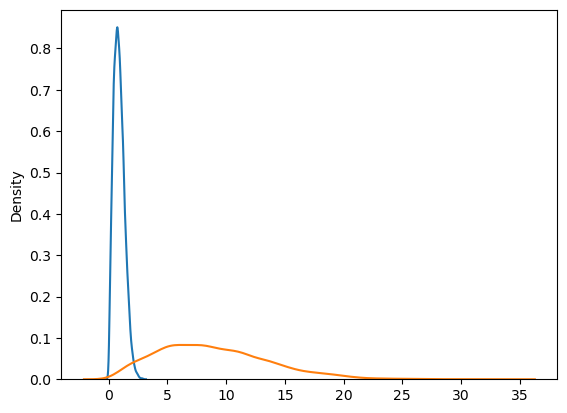

In [8]:
shape_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=1, size=10_000))
scale_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=10, size=10_000))

sns.kdeplot(shape_prior)
sns.kdeplot(scale_prior);

In [9]:
with pm.Model() as m1:
    r = pm.Weibull("r",alpha=2, beta=1)
    alpha = pm.Weibull("alpha", alpha=2, beta=10)
    s = pm.Weibull("s",alpha=2, beta=1)
    beta = pm.Weibull("beta", alpha=2, beta=10)
    llike = ParetoNBD("llike", r=r, alpha=alpha, s=s, beta=beta, T=T, observed=np.stack((t_x, x), axis=1))

pm.logp(llike, np.stack((t_x, x), axis=1)).sum().eval(dict(zip((r, alpha, s, beta), lt_fit.values())))

/home/ricardo/miniconda3/envs/pymc-marketing/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


array(-9594.97392991)

NUTS sampling does not converge properly due to unstable gradients in the ParetoNBD logp function, so we must use the Slice Sampler instead.

Note the rhat statistic warning here: This means the MCMC sampling chains are not identically distributed. It is recommended to do at least 2000 draws with the Slice Sampler.

In [10]:
with model:   
    with warnings.catch_warnings():
        warnings.filterwarnings(
            message="Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.",
            action="ignore",
            category=UserWarning,
        )
        # Default NUTS is too slow. 
        # In the pymc-experimental we include a special rewrite that speeds up the gradient evaluations
        idata_mcmc = pm.sample(step=pm.Slice(), draws=2000)
        idata_map = pm.find_MAP(include_transformed=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [r]
>Slice: [alpha]
>Slice: [s]
>Slice: [beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 87 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
idata_map

{'r': array(0.55961892),
 'alpha': array(10.59116019),
 's': array(0.55028984),
 'beta': array(9.75557741)}

In [17]:
az.summary(idata_mcmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.562,0.045,0.479,0.648,0.002,0.001,587.0,1276.0,1.01
alpha,10.689,0.832,9.152,12.288,0.028,0.020,873.0,1589.0,1.01
s,0.612,0.120,0.402,0.839,0.007,0.005,293.0,722.0,1.02
beta,11.778,3.837,5.366,19.102,0.226,0.160,267.0,584.0,1.02


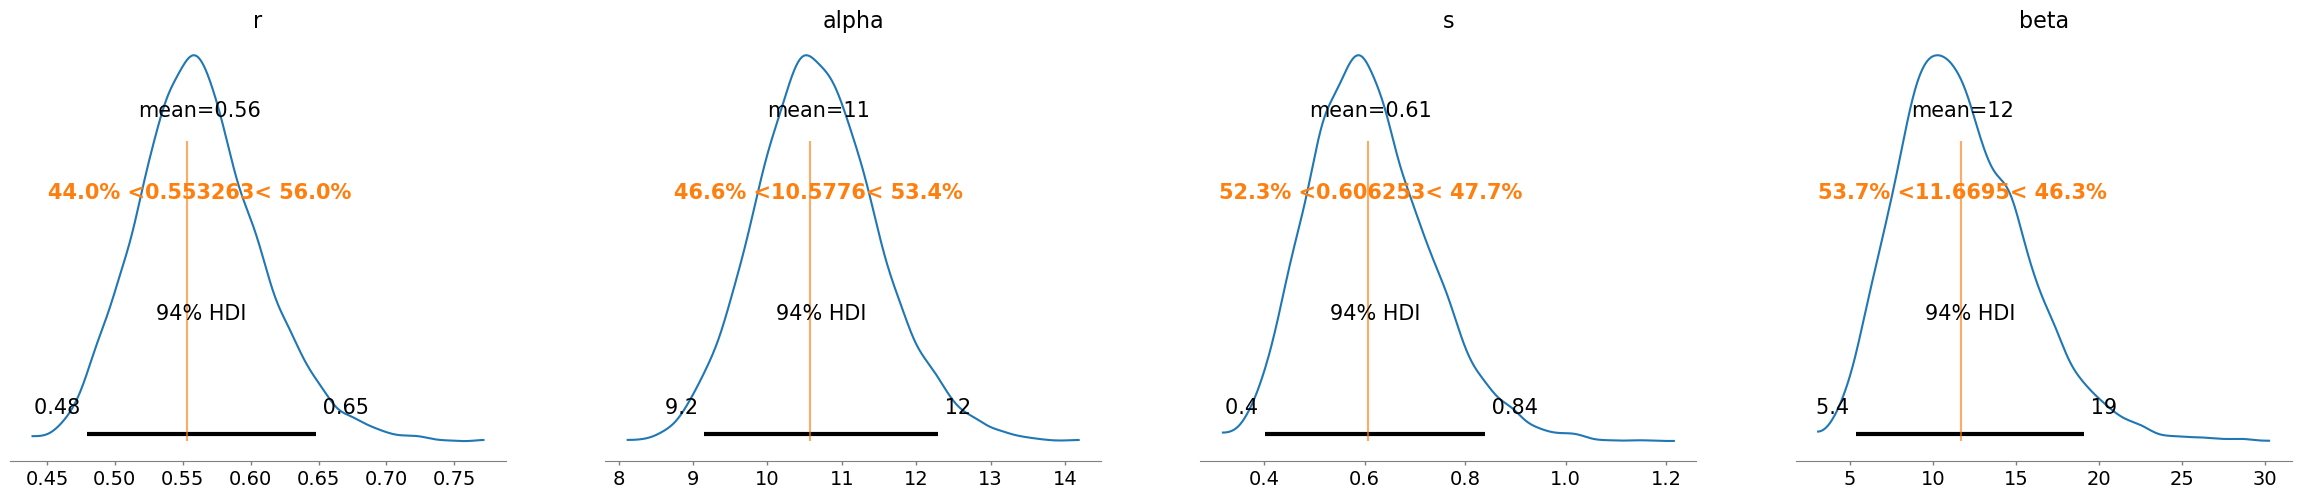

In [11]:
az.plot_posterior(idata_mcmc, ref_val=list(lt_fit.values()));

In [13]:
pnbd_map = ParetoNBDModel(df.index, x, t_x, T)
pnbd_map.fit(fit_method='map')
pnbd_map.fit_summary()

/home/ricardo/Documents/Work/Labs/pymmmc/pymc_marketing/clv/models/pareto_nbd.py:190: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(


r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64

In [14]:
pnbd_mcmc = ParetoNBDModel(df.index,x,t_x,T)
pnbd_mcmc.fit(chains=2)
pnbd_mcmc.fit_summary()

# TODO: Add internal posterior predictive methods for transaction rate and churn rate distributions, 
#       then Bayesian p-values can be plotted
#az.plot_bpv(idata, kind="t_stat", t_stat="0.5")
#plt.show()

/home/ricardo/Documents/Work/Labs/pymmmc/pymc_marketing/clv/models/pareto_nbd.py:190: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [r, alpha, s, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 411 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.565,0.046,0.484,0.657,0.002,0.001,705.0,770.0,1.0
alpha,10.712,0.830,9.217,12.360,0.031,0.022,718.0,971.0,1.0
s,0.598,0.120,0.392,0.830,0.005,0.003,670.0,745.0,1.0
beta,11.331,3.794,5.152,18.558,0.144,0.102,660.0,746.0,1.0


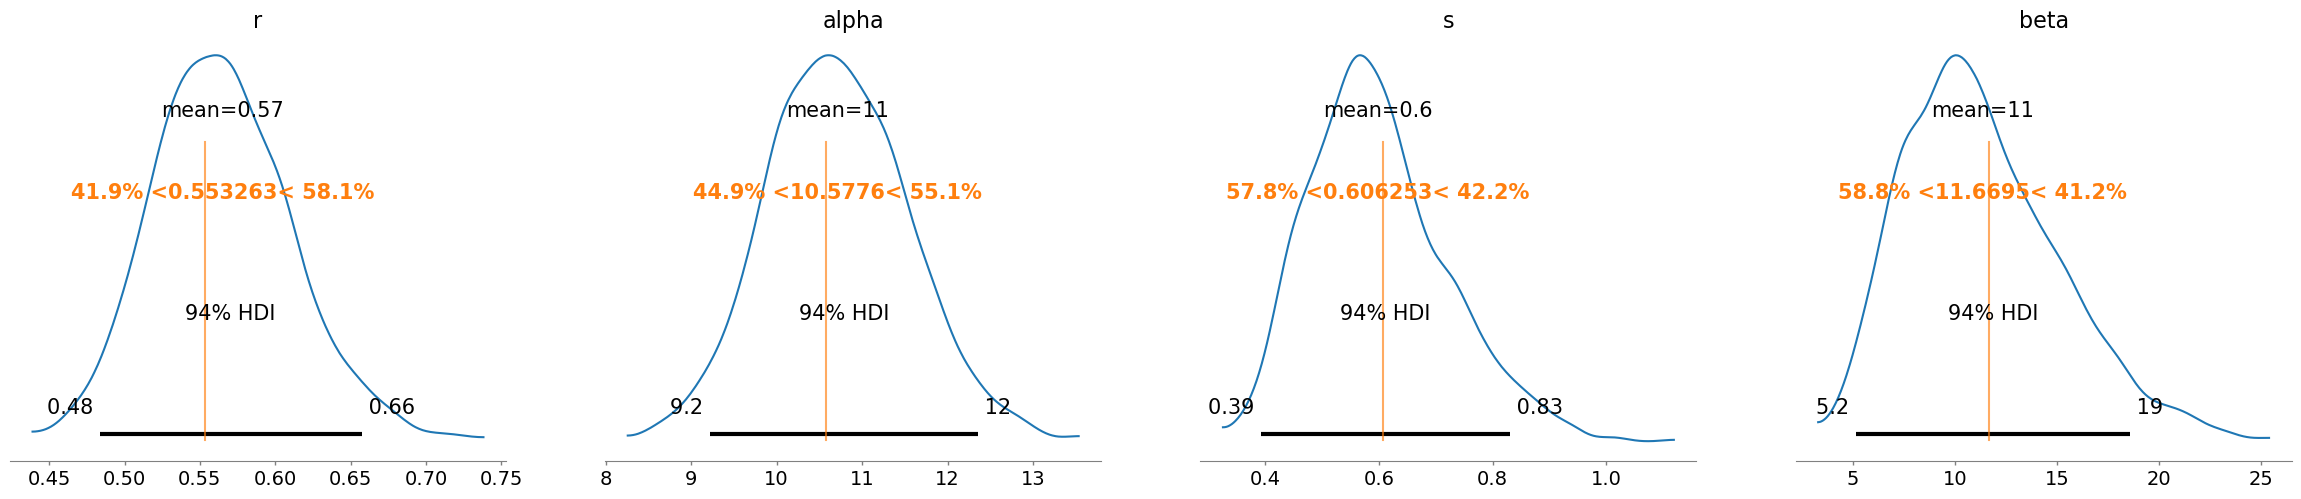

In [15]:
az.plot_posterior(pnbd_mcmc._fit_result, ref_val=list(lt_fit.values()));

### Model Predictions

In [21]:
# Append all predictive methods to a pandas dataframe
df['exp_prchs_mcmc'] = pnbd_mcmc.expected_purchases(future_t = 10).mean(("chain", "draw"))
df['exp_prchs_map'] = pnbd_map.expected_purchases(future_t = 10).mean(("chain", "draw"))

df['prob_alive_mcmc'] = pnbd_mcmc.expected_probability_alive(future_t = 10).mean(("chain", "draw"))
df['prob_alive_map'] = pnbd_map.expected_probability_alive(future_t = 10).mean(("chain", "draw"))

df['prchs_prob_mcmc'] = pnbd_mcmc.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))
df['prchs_prob_map'] = pnbd_map.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))

# This value does not change from customer to customer, but is shown here for completeness
df['new_customer_mcmc'] = pnbd_mcmc.expected_purchases_new_customer(t = 100).mean().values
df['new_customer_map'] = pnbd_map.expected_purchases_new_customer(t = 100).mean().values

# For single customer predictions, arguments must still be provided as lists or numpy arrays
# Array lengths must match for all arguments
pnbd_mcmc.expected_purchases(future_t = 10,
                             customer_id = [1000],
                             frequency = np.array([3]),
                             recency = [20],
                             T = [30]).mean(("chain", "draw"))

# Use a for loop or list comprehension to iterate over multiple arguments:
[pnbd_mcmc.expected_purchases(future_t = t) for t in [10,9,8]]

df.head(10)

,frequency,recency,T,monetary_value,exp_prchs_slice,exp_prchs_map,prob_alive_slice,prob_alive_map,exp_prchs_mcmc,prob_alive_mcmc,prchs_prob_mcmc,prchs_prob_map,new_customer_mcmc,new_customer_map
0,2,30.43,38.86,22.35,0.426653,0.429898,0.782343,0.789804,0.426653,0.782343,0.081508,0.082505,2.23704,2.257801
1,1,1.71,38.86,11.77,0.049917,0.050083,0.150253,0.151008,0.049917,0.150253,0.008501,0.008571,2.23704,2.257801
2,0,0.00,38.86,0.00,0.031351,0.031521,0.262380,0.264870,0.031351,0.262380,0.003725,0.003761,2.23704,2.257801
3,0,0.00,38.86,0.00,0.031351,0.031521,0.262380,0.264870,0.031351,0.262380,0.003725,0.003761,2.23704,2.257801
4,0,0.00,38.86,0.00,0.031351,0.031521,0.262380,0.264870,0.031351,0.262380,0.003725,0.003761,2.23704,2.257801
5,7,29.43,38.86,73.74,1.088379,1.102017,0.676675,0.685516,1.088379,0.676675,0.109447,0.110536,2.23704,2.257801
6,1,5.00,38.86,11.77,0.076629,0.077453,0.230584,0.233532,0.076629,0.230584,0.013057,0.013254,2.23704,2.257801
7,0,0.00,38.86,0.00,0.031351,0.031521,0.262380,0.264870,0.031351,0.262380,0.003725,0.003761,2.23704,2.257801
8,2,35.71,38.86,25.55,0.469745,0.471763,0.861283,0.866718,0.469745,0.861283,0.089723,0.090540,2.23704,2.257801
9,0,0.00,38.86,0.00,0.031351,0.031521,0.262380,0.264870,0.031351,0.262380,0.003725,0.003761,2.23704,2.257801


# Formatting Data From Raw Transactions
Why isn't clv_summary() working here?

In [22]:
d = [
        [1, "2015-01-01", 10.11],
        [1, "2015-02-06", 20.12],
        [2, "2015-01-01", 26.13],
        [3, "2015-01-01", 33.2],
        [3, "2015-01-02", 11.12],
        [3, "2015-01-05", 55.1],
        [4, "2015-01-16", 66.12],
        [4, "2015-02-02", 33.1],
        [4, "2015-02-05", 31.1],
        [5, "2015-01-16", 39.7],
        [5, "2015-01-17", 19.5],
        [5, "2015-01-18", 80.1],
    ]

raw_trans = pd.DataFrame(d, columns=["customer_id", "purchase_date", "monetary_value"])
raw_trans['purchase_date'] = pd.to_datetime(raw_trans['purchase_date'])
raw_trans

clv_summary(raw_trans,"customer_id","purchase_date","monetary_value")

# TODO: Why isn't CLV_Summary working here?
# url_cdnow_trans = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/tests/clv/datasets/cdnow_transactions.csv"
# raw_trans = pd.read_csv(url_cdnow_trans)
# raw_trans['date'] = raw_trans['date'].astype(int)
# df_rfm = clv_summary(url_cdnow_trans,"id","date","spent")

,customer_id,frequency,recency,T,monetary_value
0,1,1.0,36.0,36.0,20.12
1,2,0.0,0.0,36.0,0.00
2,3,2.0,4.0,36.0,33.11
3,4,2.0,20.0,21.0,32.10
4,5,2.0,2.0,21.0,49.80
